In [70]:
# Cálcula el porcentaje de error entre dos series de maáximos anuales.

import itertools

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [71]:
# Archivo 1.
i = 0
# Archivo 2.
j = 2
# Cantidad de celdas a eliminar del borde.
k = 1

name = [ "CHIRPS_comp", "CHIRPS_megalopolis", "prec_hist_comp_CHIRPS",
    "prec_hist_comp_estaciones", "prec_hist_hist" ]

path_orig   = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 
path_comp   = "../results/" + name[j] + "/" + name[j] + "_tretorno.nc" 
path_orig_s = "../results/" + name[i] + "/" + name[i] + "_stats.nc" 
path_comp_s = "../results/" + name[j] + "/" + name[j] + "_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

In [72]:
# Comparamos las estadísticas mensuales.
comp_stat.to_dataframe().xs( 3, level = "ESTADISTICA" )

PRECIPITACION
LATITUD   LONGITUD    MES               
18.224998 -100.375008 1         1.111408
                      2         2.730481
                      3         0.306144
                      4         0.042654
                      5         5.240294
...                                  ...
20.574997 -97.425003  8         9.013741
                      9        17.816092
                      10       25.175303
                      11       22.041834
                      12       31.541351

[34560 rows x 1 columns]

In [73]:
# Comparamos las estadísticas mensuales.
orig_stat.to_dataframe().xs( 3, level = "ESTADISTICA" )

PRECIPITACION
LATITUD   LONGITUD    MES               
18.224998 -100.375008 1         9.414705
                      2         1.642056
                      3         2.175767
                      4         1.027315
                      5        26.822191
...                                  ...
20.574997 -97.425003  8       130.895554
                      9       206.432266
                      10      141.043503
                      11      100.851295
                      12       54.702038

[34560 rows x 1 columns]

In [74]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf("../results/comp/comp_hist_CHIRPS_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre CHIRPS_comp y prec_hist_comp_CHIRPS
count: 34560.00
mean: 0.86
std: 1.22
min: -0.99
25%: 0.17
50%: 0.71
75%: 1.32
max: 53.65


In [75]:
# Error total.
error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ))
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf("../results/comp/comp_hist_CHIRPS.nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre CHIRPS_comp y prec_hist_comp_CHIRPS
count: 1071360.00
mean: 0.74
std: 0.57
min: -0.91
25%: 0.44
50%: 0.79
75%: 1.08
max: 8.51


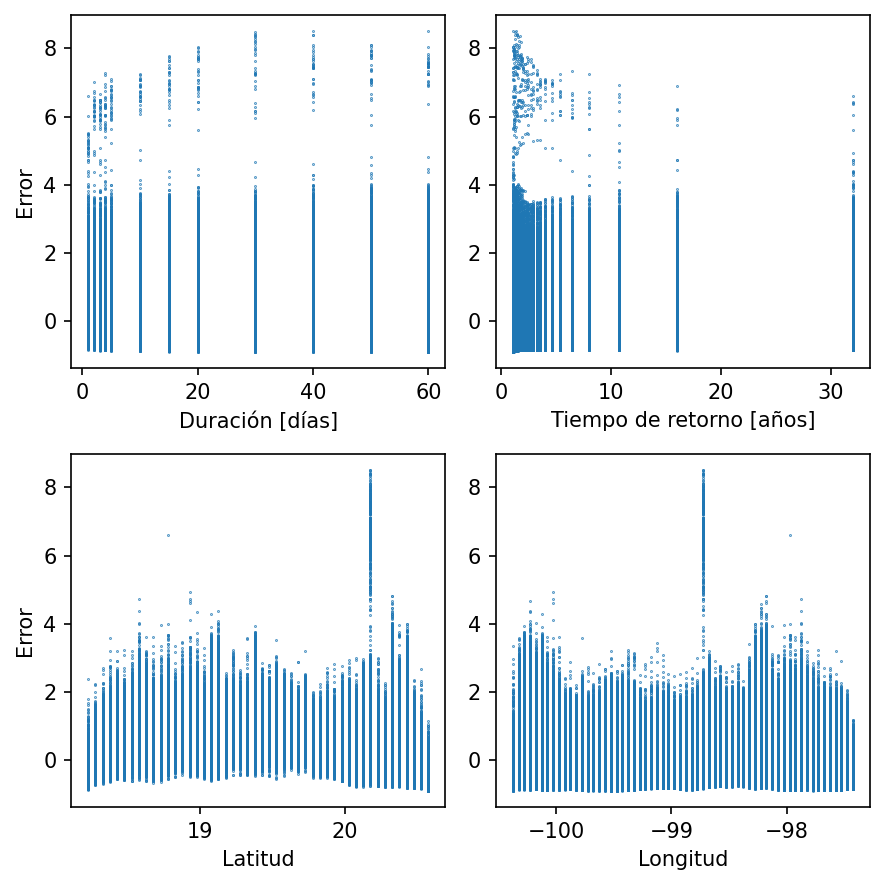

In [76]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

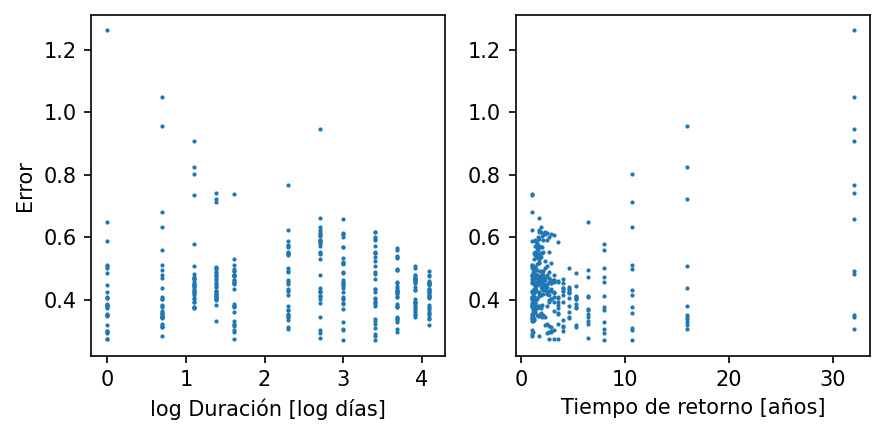

In [91]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 15
N = 15
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
ax[1].set_xlabel(f"Tiempo de retorno [años]")

fig.tight_layout()
plt.show()

In [98]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log( df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.log( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              "DURACION",
                              "TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              #"T_1",
                              "T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     20.63
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.38e-15
Time:                        18:30:04   Log-Likelihood:                 303.89
No. Observations:                 372   AIC:                            -597.8
Df Residuals:                     367   BIC:                            -578.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4307      0.016     27.729      0.000       0.400       0.461
DURACION          -0.0026      0.001     -3.901      0.000      -0.004      -0.001
TIEMPO_RETORNO     0.0142      0.002      7.407      0.000       0.010       0.018
D_1                0.0323      0.010      3.233      0.001       0.013       0.052
T_2               -0.0658      0.014     -4.798      0.000      -0.093      -0.039
==============================================================================
Omnibus:                       76.921   Durbin-Watson:                   0.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.937
Skew:                           0.868   Prob(JB):                     6.00e-62
Kurtosis:                       6.896   Cond. No.                         93.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST", "C_LOG_DUR", "C_LOG_TRET", "C_DUR", "C_TRET",
        "P_CONST", "P_LOG_DUR", "P_LOG_TRET", "P_DUR", "P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            "LOG_DURACION", "LOG_TRETORNO",
            "DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

# Guardamos el archivo.
df_s.to_xarray().to_netcdf("../results/comp/comp_hist_CHIRPS_reglin.nc")

print( "Media de R^2" )
print( f"{df_s.to_xarray()['ADJ_R_SQUARED'].mean().values + 0:.3f}" )
print( "Desviación estándar de R^2" )
print( f"{df_s.to_xarray()['ADJ_R_SQUARED'].std().values + 0:.3f}" )

Media de R^2
0.524
Desviación estándar de R^2
0.239


In [80]:
# Calcula la intensidad de precipitación corregida.

# Generamos las variables de manera matricial.
T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    (62 - k * 2, 50 - k * 2, 12, 31) )[:, :, :, 0:31]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    (62 - k * 2, 50 - k * 2, 31, 12) )[:, :, :, 0:12], 3, 2 ) 
B0 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["CONST"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )
B1 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_DURACION"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )
B2 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_TRET"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )

# Predicción.
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_comp.drop( ["AÑO"] ).copy()
ds_corr["INTENSIDAD"] = ( list( ds_orig.dims ),
    np.swapaxes( ds_corr["INTENSIDAD"].to_numpy(), 0, 1) / ( REG + 1 ) )

# Guardamos.
ds_corr.to_netcdf("../temp/prec_hist_hist_corr.nc")

In [81]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Int64Index([], dtype='int64', name='DURACION')


,,PROBABILIDAD
LATITUD,LONGITUD,


In [82]:
# Comparamos valores originales y corregidos.
ds_corr.to_dataframe()

INTENSIDAD  PROBABILIDAD
LATITUD   LONGITUD    DURACION TIEMPO_RETORNO                         
18.224998 -100.375008 1        1.032258        20.103831       0.96875
                               1.066667        30.689883       0.93750
                               1.103448        31.199929       0.90625
                               1.142857        32.147392       0.87500
                               1.185185        33.304201       0.84375
...                                                  ...           ...
20.574997 -97.425003  60       6.400000         8.268333       0.15625
                               8.000000         7.898815       0.12500
                               10.666667        7.699898       0.09375
                               16.000000        8.678263       0.06250
                               32.000000        8.259276       0.03125

[1071360 rows x 2 columns]

In [83]:
# Comparamos valores originales y corregidos.
ds_orig.to_dataframe()

AÑO  INTENSIDAD  PROBABILIDAD
LONGITUD    LATITUD   DURACION TIEMPO_RETORNO                                
-100.375008 18.224998 1        1.032258        2015   27.160156       0.96875
                               1.066667        1994   27.834961       0.93750
                               1.103448        2000   29.351562       0.90625
                               1.142857        2009   29.964844       0.87500
                               1.185185        2011   32.638672       0.84375
...                                             ...         ...           ...
-97.425003  20.574997 60       6.400000        2005   10.274283       0.15625
                               8.000000        2009   10.296159       0.12500
                               10.666667       1998   10.795215       0.09375
                               16.000000       2013   10.981413       0.06250
                               32.000000       1999   12.277116       0.03125

[1071360 rows x 3 columns]

In [84]:
# Dsitribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf("../results/comp/comp_hist_CHIRPS_espacial.nc")